In [1]:
# import packages
import numpy as np
# import scipy.integrate as integrate
# from sympy import *
import time

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation

from matplotlib import cm
from matplotlib.ticker import LinearLocator
## set default plot size
plt.rcParams["figure.figsize"] = (10, 7)
# plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.dpi"] = 72
## set global font size
plt.rcParams.update({'font.size':14})

# import astropy.units as u
from astropy import constants as const

from scipy.interpolate import interp1d
import scipy.stats


# Leapfrogging Particle Trajectories

This notebook focuses on computing and animating the trajectories of individual particles within our two-hammer potential rather than the full solution $\delta f$. I will do this by numerically solving Hamilton's equations, which won't necessarily assume delta-function perturbations.

# Hamilton's equations

We still consider a two-hammer, isothermal slab potential. However, let's rewrite the hammers such that they're Gaussians in time (rather than delta functions). Let $\sigma_t$ characterizes the timescale of the interaction. For now, let's set $\sigma_t = 0.01$. (If a galaxy travels vertically through the MWG at ~1000 km/s, then $\sigma_t \sim 0.03$.) A normalized Gaussian function has the form

$$g(x) = \frac{1}{\sigma\sqrt{2\pi}} \text{exp}\left(-\frac{(x-\mu)^2}{2\sigma^2} \right) $$

Then the dimensionless Hamilton's equations are

$$ \frac{d\theta}{dt} = \frac{\partial \mathcal{H} }{\partial J} = \Omega(J) = \frac{1}{\sqrt{2}} \left[1+\frac{3\sqrt{2}}{\pi^2}J\right]^{-1/3} $$
$$ \frac{d J}{dt} = - \frac{\partial \mathcal{H} }{\partial \theta} = n_1 A_1 \sin(n_1\theta) \cdot \frac{1}{\sigma_t \sqrt{2\pi}} \text{exp}\left(-\frac{(t-t_1)^2}{2\sigma_t^2} \right) + n_2 A_2 \sin(n_2 \theta) \cdot \frac{1}{\sigma_t \sqrt{2\pi}} \text{exp}\left(-\frac{(t-t_2)^2}{2\sigma_t^2} \right) $$

### Draw from an arbitrary distribution

Source: https://stackoverflow.com/a/64288861

In [2]:
def inverse_sample_decorator(dist):
    
    # for now, set our maximum J to 40
    def wrapper(pnts, x_min=0, x_max=40, n=1e5, **kwargs):
        
        x = np.linspace(x_min, x_max, int(n))
        cumulative = np.cumsum(dist(x, **kwargs))
        cumulative -= cumulative.min()
        f = interp1d(cumulative/cumulative.max(), x)
        return f(np.random.random(pnts))
    
    return wrapper

In [3]:
## define the slab Omega, Hamiltonian, and f0(J)

def compute_Omega(J):
    '''
    Represents (dimensionless) Omega(J). We use Omega = a/(1 + b*J)^(1/3)
    
    '''
    
    a = 1. / np.sqrt(2)
    b = 3 * np.sqrt(2) / pow(np.pi,2)

    return a * pow(1 + b*J, -1/3)

def Hamiltonian(J):
    '''
    Computes the Hamiltonian of our system by integrating Omega(J)
    from 0 to J. (Underneath Eq. 8 in Scott's paper, it's stated that
    Omega = dH/dJ.) We assume that Omega=0 for H=0.
    
    We use Omega = a/(1 + b*J)^(1/3) and its analytical antiderivative.
    
    '''
    
    term1 = np.pi**2 / 4
    b = 3*np.sqrt(2) / (np.pi**2)
    
    term2 = (1 + b*J)**(2/3)
    return term1 * term2


def f_0(J): 
    '''
    Initial distribution function of our system, using Eq. 6 of Scott's
    paper.
    
    '''
    
    return np.exp(-1*Hamiltonian(J)) / np.sqrt(2 * np.pi)

@inverse_sample_decorator
def f_0_distro(J): 
    '''
    The version of f_0(J) we use to perform inverse transform sampling.
    
    '''
    
    return np.exp(-1*Hamiltonian(J)) / np.sqrt(2 * np.pi)

## convert from $(\theta, J)$ to $(z,v_z)$

In [4]:
## basic function for converting (thetas, Js) to (x_vals, y_vals)

def pol2cart(thetas, Js):
    '''
    Given a set of angles and actions (thetas, Js), return the 
    corresponding Cartesian coordinates.
    
    '''
    
    zs = np.sqrt(2*Js / compute_Omega(Js)) * np.sin(thetas)
    vzs = np.sqrt(2*Js*compute_Omega(Js)) * np.cos(thetas)
    
    return zs, vzs

# Outline

Let N be the number of particles I'm simulating. (I should test N=1, 10, 100, ...). Our plan is:

1. Keep two N-length arrays, one representing the $\theta$'s of all the particles and one representing all the $J$'s at a certain timepoint $t_i$.
2. Keep an array with timepoints, e.g., `ts = np.arange(0, 300, 0.5)`.
3. Set the initial conditions. Each $J_0$ should be in $(0, 20)$, while each $\theta_0$ should be in $[0, 2\pi)$.
4. **Use leapfrog to update $\theta$, $J$, and $\Omega(J)$ at every timestep.** (This step differs from simply evolving the trajectories given hammer perturbations.)

In [11]:
## define hammer params, phase space range

# define the parameters of the two hammers (t_i, n_i, A_i)
t1, t2 = 0, 100
n1, n2 = 1, 3
A1, A2 = 0.1, 0.2

# define ts, thetas, and Js; and, corresponding Cartesian coords
N = (int) (5e6) # number of particles

# time range
tmin = 0
tmax = 250
tstep = 0.5
ts = np.arange(tmin, tmax+tstep, tstep)

# Monte Carlo sample our initial conditions
np.random.seed(2)
thetas = (2*np.pi) *np.random.rand(N)
Js = f_0_distro(N) # drawn from f_0(J)

# initial Omega values
Omegas = compute_Omega(Js)

# convert to z, v_z
zs, vzs = pol2cart(thetas, Js)


To calculate $\delta n / n_0$ at a certain position ($z=z'$), we'll define the quantity $n(t)$ as the spatial density at that point. Here, we approximate $n(t)$ as the number of particles in a certain z bin divided by the width of the bin. By definition, $n(0) = n_0$, i.e., the background or equilibrium value.

Therefore:

$$\frac{\delta n}{n_0} \Big|_{z=z'} = \frac{n(t) - n(0^-)}{n(0)}\Big|_{z=z'}.$$

In [15]:
# calculate n_0 and plot initial condition
z_tolerance = 5e-2
plot_initial_distro = False

# number of particles at t=0 within z_tolerance at a z coordinate; this is the
# "background" distribution
z_offset = 7.8
n_0 = np.sum(np.abs(zs - z_offset) < z_tolerance)
print(f'n_0 = {n_0}')

if plot_initial_distro:
    fig = plt.figure(figsize=(10,10))

    xlimit = 12
    ylimit = 5
    plt.xlim(-xlimit, xlimit)
    plt.ylim(-ylimit, ylimit)

    plt.xlabel(r"$z$")
    plt.ylabel(r"$v_z$")

    plt.title('Particles right before hammer 1')

    plt.show()

n_0 = 297


# Animation

In [13]:
def dtheta_dt(J):
    
    '''
    Represents the RHS of dtheta / dt = dH/dJ = Omega(J) for a given
    J and at a given timepoint t. (Since Omega is independent of t,
    I will omit t as a funciton parameter.)
    
    '''
    
    return compute_Omega(J)

def dJ_dt(theta, t):
    '''
    
    Represents the RHS of dJ / dt = -dH/dtheta for a given
    theta and at a given timepoint t. Used in leapfrog.
    
    '''
    sigma_t = 0.01 # timescale of interaction
    
    hammer1 = n1 * A1 * np.sin(n1 * theta) * scipy.stats.norm.pdf(t, loc=t1, scale=sigma_t)
    hammer2 = n2 * A2 * np.sin(n2 * theta) * scipy.stats.norm.pdf(t, loc=t2, scale=sigma_t)
    
    return hammer1 + hammer2

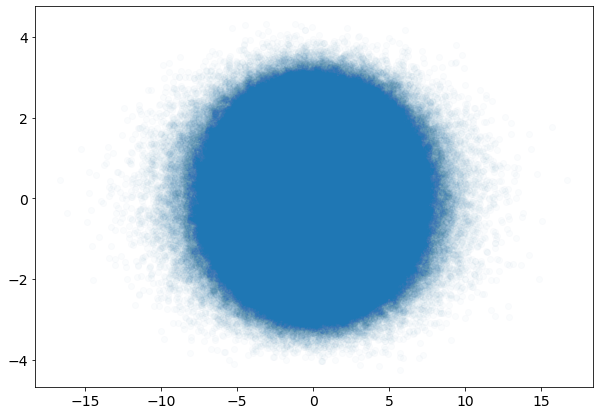

In [16]:
# make the animation
scat = plt.scatter(zs, vzs, alpha=0.02)

make_animation=False
if make_animation:
    zs, vzs = pol2cart(thetas, Js)
    fig = plt.figure(figsize=(10,10))
    xlimit = 12
    ylimit = 5
    plt.xlim(-xlimit, xlimit)
    plt.ylim(-ylimit, ylimit)

    plt.xlabel(r"$z$")
    plt.ylabel(r"$v_z$")

# the "density" at z=0 (in practice, the number of points near z=0) as a function of time
delta_n_over_ns = []

start = time.time()

# simulating pointers with a dictionary... not ideal but we'll see if it works
# source: https://realpython.com/pointers-in-python/#using-python-objects
# WARNING: editing these variables' contents also edits the contents of thetas, Js
variables = {"hammer1_has_hit": False, "hammer2_has_hit": False, \
             "thetas": thetas, "Js": Js, "J_halfs": np.empty_like(Js), "Omegas": Omegas}

def updatefig(i):
    t = ts[i]
    
    if ((t % 10) == 0):
        print("t = " + str(t))
        print(f'Elapsed t: {np.round(time.time() - start, 1)} seconds')

    # calculate next thetas, Js using leapfrog
    # kick
    variables["J_halfs"] = variables["Js"] + (dJ_dt(variables["thetas"], t)*tstep/2)
    # drift
    thetas_next_step = variables["thetas"] + dtheta_dt(variables["J_halfs"])*tstep
    thetas_next_step = np.mod(thetas_next_step, 2*np.pi)
    # kick
    Js_next_step = variables["J_halfs"] + (dJ_dt(thetas_next_step, t+tstep)*tstep/2)

    # update thetas, Js
    variables["thetas"] = thetas_next_step
    variables["Js"] = Js_next_step
    
    J_is_negative = (variables["Js"] < 0)
    
    ## move negative-J particles to J~0 orbits
    move_negative_J_particles = True
    if move_negative_J_particles:
        variables["Js"][J_is_negative] = 0
    
    ## convert coordinates to (z, v_z)
    hide_negative_J_particles = False
    if hide_negative_J_particles:
        zs, vzs = pol2cart(variables["thetas"][~J_is_negative], 
                           variables["Js"][~J_is_negative])
    else:
        zs, vzs = pol2cart(variables["thetas"], 
                           variables["Js"])
    
    ## compute delta n / n_0, ie, number density contrast
    
    # number of particles at t=0 within z_tolerance of our selected z coordinate
    n_t = np.sum(np.abs(zs - z_offset) < z_tolerance)
    delta_n_over_n = (n_t - n_0) / n_0
    delta_n_over_ns.append(delta_n_over_n)
    
    # make plot
    data = np.transpose((zs, vzs))
    scat.set_offsets(data)
    plt.legend(title=f"t={t}", loc='upper left', labelspacing=0.)
    
    save_fig = False
    if save_fig:
    # save figure at certain snapshots
        if t in ts_for_savefig:
            plt.savefig(f'Leapfrogging trajectories (thesis)/Leapfrog_trajs_t={t}.png', dpi=300)
            
    return scat,


make_animation = False
if make_animation:
    ani = animation.FuncAnimation(fig, updatefig, interval=100, frames=len(ts), \
            blit=True)
    ani.save("Leapfrogged_trajectories_temp.mp4")

t = 0.0
Elapsed t: 0.0 seconds


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


KeyboardInterrupt: 

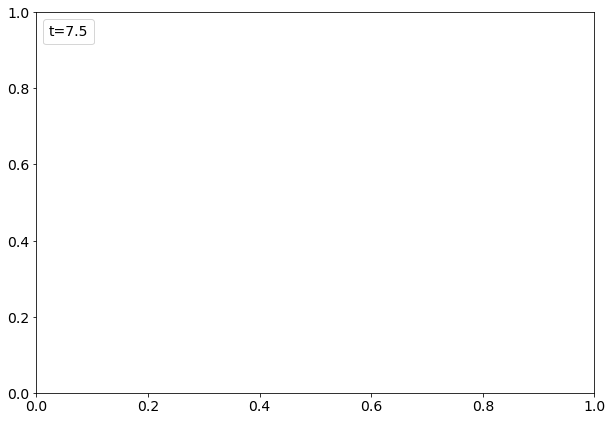

In [17]:
# calculate delta_n_over_ns array, avoiding the animation
start = time.time()
delta_n_over_ns = []

# define a longer time range than in the animation
tmin = 0
tmax = 250
tstep = 0.5
ts = np.arange(tmin, tmax+tstep, tstep)

for i in range(len(ts)):
    updatefig(i)

In [ ]:
plt.plot(ts, delta_n_over_ns)

plt.xlabel('t')
plt.ylabel('$\delta n/n_0$')
plt.title(f'Density contrast at z={z_offset}, z_tolerance={z_tolerance}')

save_fig = False
if save_fig:
    plt.savefig('leapfrog_deltan_N={N:.1E}.png')
plt.show()